# NLSY (Random Forests)

## Load Libraries and Data

In [1]:
import io
import requests
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import (BaggingClassifier, VotingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)                              
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)

# Options for plots
%matplotlib inline
sns.set()
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 12

In [2]:
def plot_decision_boundary(
    clf, X, y, classes, features, xlims,
    markers=['<', 'o', 's'],
    markercolors=['darkgreen', 'navy', 'darkred'],
    fillcolors=['lightgreen', 'cornflowerblue', 'lightcoral'],
    steps=1000, alpha=0.2, figsize=(15, 6)
):
    x1, x2 = np.meshgrid (np.linspace(*xlims[0], steps).reshape(-1, 1),
                          np.linspace(*xlims[1], steps).reshape(-1, 1))
    
    X_bound = np.c_[x1.ravel(), x2.ravel()]
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        y_pred = clf.predict(X_bound)
        
    z = LabelEncoder().fit_transform(y_pred).reshape(x1.shape)
    
    plt.figure(figsize=figsize)
    
    for i, c in enumerate(classes):
        plt.plot(X.loc[y == c, features[0]], X.loc[y == c, features[1]],
                 color=markercolors[i], marker=markers[i],
                 linestyle='none', label=c)
    
    plt.contourf(x1, x2, z, levels=len(classes) + 1,
                 alpha=alpha, cmap=ListedColormap(fillcolors))
   
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.show()

In [3]:
# Split data and return as dataframes
def split_data(X, y, test_size=0.2, stratify=None,
               random_state=1):
    out = train_test_split(X, y, test_size=test_size,
                           stratify=stratify,
                           random_state=random_state)
    out[0] = pd.DataFrame(out[0], columns=X.columns)
    out[1] = pd.DataFrame(out[1], columns=X.columns)

    return out

### Data Description

The Bureau of Labor Statistics administers a National Longitudinal Survey of Youth that tracks individuals over the course of their lives.

The 1979 (NLSY79) cohort includes men and women born in the USA between 1957 and 1964.

In the data set, each row represents an individual that participates in the 1979 cohort.

| Attribute      | Definition                                                                                   |
| -------------- | -------------------------------------------------------------------------------------------- |
| ID             | Participant identifier assigned by BLS                                                       |
| Earnings       | Annual wage earnings 2014                                                                    |
| WeeksWorked    | Count of weeks worked in 2014                                                                |
| CumWeeksWorked | Cumulative weeks of work experience during study                                             |
| Education      | Years of education as of 2014                                                                |
| IQ             | Percentile on IQ test taken in 1979                                                          |
| Gender         | Participant's gender                                                                         |
| MSA            | Did the participant reside within an urban cluster or urbanized area in 2014?                |
| Library        | Did the participant, or someone in the participant's household, have a library card in 1979? |
| Esteem         | Score on the Rosenberg Self-Esteem Scale in 1979                                             |

In [4]:
url = 'https://raw.githubusercontent.com/natecraig/aiml/main/Data/nlsy.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head()

,ID,Earnings,WeeksWorked,CumWeeksWorked,Education,IQ,Gender,MSA,Library,Esteem
0,83,0,3,553.0,10,2,Male,Yes,Yes,18
1,84,0,3,107.0,12,9,Male,Yes,Yes,20
2,87,11500,5,759.0,12,5,Male,Yes,Yes,22
3,105,20501,11,979.0,12,84,Female,Yes,Yes,19
4,178,59000,46,1010.0,16,99,Male,No,Yes,24


In [5]:
# Return index of education category as a function of years of education
def education_category(years_education):
    if years_education < 16:
        return 'High School'
    elif years_education == 16:
        return 'Undergraduate'
    else:
        return 'Graduate'


# Create a variable to contain each participant's education category    
df['EducationCategory'] = df['Education'].apply(education_category)
df['EducationCategory'].value_counts(normalize=True)

High School      0.830679
Undergraduate    0.113160
Graduate         0.056161
Name: EducationCategory, dtype: float64

In [6]:
# Predict EducationCategory as a function of Earnings and WeeksWorked
feature_vars = ['Earnings', 'WeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = split_data(X, y, test_size=0.25,
                               stratify=y,
                               random_state=random_state)

## Simple Ensemble

In [7]:
# Use logistic regression, decision tree, and k-nearest neighbors classifiers
log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                             random_state=random_state)
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=random_state)
knn_clf = KNeighborsClassifier(n_neighbors=4)

voting_clf = VotingClassifier(
    estimators=[('logreg', log_clf), ('tree', tree_clf),
                ('knn', knn_clf)],
    voting='soft'
)

In [8]:
# Evaluate voting classifier on the training data
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

               precision    recall  f1-score   support

     Graduate      1.000     0.294     0.455        17
  High School      0.939     0.988     0.963       248
Undergraduate      0.606     0.588     0.597        34

     accuracy                          0.903       299
    macro avg      0.848     0.623     0.671       299
 weighted avg      0.904     0.903     0.892       299



In [9]:
for clf in voting_clf.estimators_:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('{:<24} {:.3f}'.format(clf.__class__.__name__,
                                 accuracy_score(y_test, y_pred)))

LogisticRegression       0.749
DecisionTreeClassifier   0.893
KNeighborsClassifier     0.883


In [10]:
# Fit the voting classifier
voting_clf.fit(X_train, y_train)

idx = 1
instance = X_test.iloc[idx, :].to_numpy().reshape(1, -1)
instance = pd.DataFrame(instance, columns=X_test.columns)

print('{:<40} {:>16}\n'.format('Actual', y_test.iloc[idx]))
print('{:<40} {:>16}\n'.format('Voting classifier prediction',
                             voting_clf.predict(instance)[0]))

for clf in voting_clf.estimators_:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(instance)
    print('{:<40} {:>16}'.format(clf.__class__.__name__ + ' prediction',
                                 y_pred[0]))

Actual                                      Undergraduate

Voting classifier prediction                Undergraduate

LogisticRegression prediction               Undergraduate
DecisionTreeClassifier prediction           Undergraduate
KNeighborsClassifier prediction                  Graduate


### Exercise
Add the remaining variables to the voting classifier and observe how accuracy changes. Keep in mind that you may need to change the arguments for the constituent classifiers (e.g., max_iter for LogisticRegression).

## Bagging and Pasting

In [11]:
# Fit a bagging classifier using decision trees
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=random_state, max_depth=6),
    n_estimators=1000, max_samples=500, bootstrap=True,
    random_state=random_state
)
bag_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = bag_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

               precision    recall  f1-score   support

     Graduate      0.778     0.412     0.538        17
  High School      0.957     0.980     0.968       248
Undergraduate      0.611     0.647     0.629        34

     accuracy                          0.910       299
    macro avg      0.782     0.680     0.712       299
 weighted avg      0.907     0.910     0.905       299



In [12]:
# Compare the bagging classifier to a single decision tree fit to the
# full training data set
tree_clf = DecisionTreeClassifier(max_depth=6, random_state=random_state)
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

               precision    recall  f1-score   support

     Graduate      0.700     0.412     0.519        17
  High School      0.946     0.980     0.962       248
Undergraduate      0.594     0.559     0.576        34

     accuracy                          0.900       299
    macro avg      0.746     0.650     0.686       299
 weighted avg      0.892     0.900     0.893       299



### Exercise

How do the bagging classifier and the single decision tree compare when we add the CumWeeksWorked variable?

## Random Forests

In [13]:
# For a random forest, use cross validation to pick
# the number of trees (estimators) and the max depth of the trees
search_parameters = {
    'n_estimators':range(100, 400, 100),
    'max_depth':range(6, 12)
}

rnd_clf = RandomForestClassifier(n_jobs=3, random_state=random_state) 
grid_clf = GridSearchCV(rnd_clf, search_parameters)
grid_clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=3, random_state=1000),
             param_grid={'max_depth': range(6, 12),
                         'n_estimators': range(100, 400, 100)})

In [14]:
print(f'Accuracy: {grid_clf.best_score_:.3f}')
grid_clf.best_params_

Accuracy: 0.909


{'max_depth': 8, 'n_estimators': 300}

In [15]:
# Get the best classifier from GridSearchCV
best_clf = grid_clf.best_estimator_

# Get accuracy on the test data
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

               precision    recall  f1-score   support

     Graduate      0.750     0.353     0.480        17
  High School      0.957     0.976     0.966       248
Undergraduate      0.579     0.647     0.611        34

     accuracy                          0.903       299
    macro avg      0.762     0.659     0.686       299
 weighted avg      0.902     0.903     0.898       299



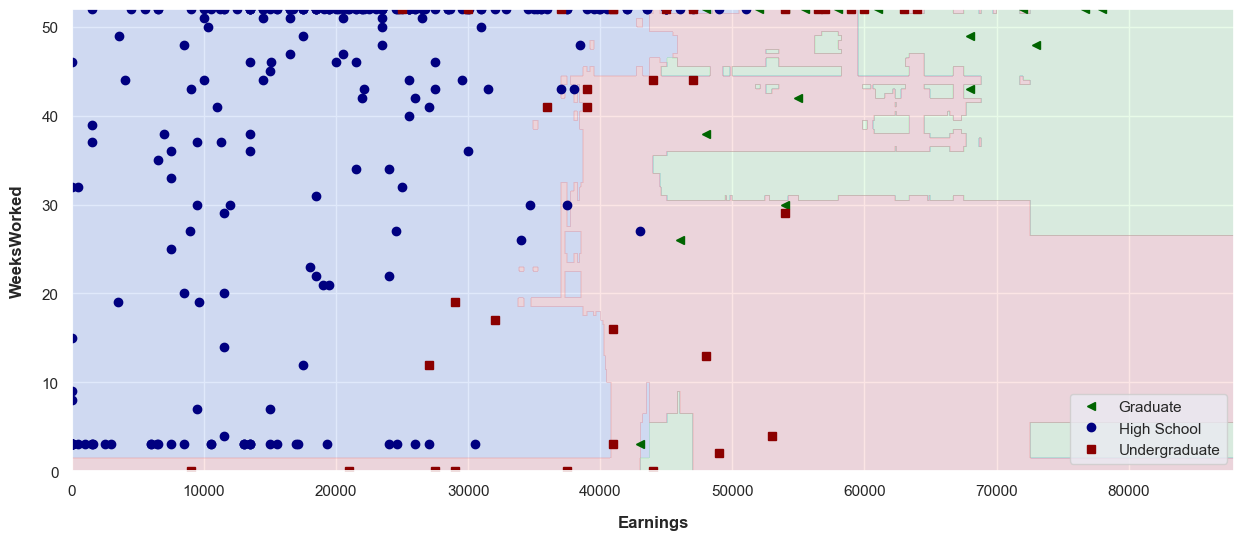

In [16]:
# Visualize decision boundaries
xlims = [
    [df['Earnings'].min(), df['Earnings'].max()],
    [df['WeeksWorked'].min(), df['WeeksWorked'].max()]
]

plot_decision_boundary(best_clf, X_test, y_test,
                       classes=['Graduate', 'High School', 'Undergraduate'],
                       features=feature_vars,
                       xlims=xlims)     

In [17]:
# Get feature importances
for name, imp in zip(feature_vars, best_clf.feature_importances_):
    print('{:<16} {:.3f}'.format(name, imp))

Earnings         0.826
WeeksWorked      0.174


In [18]:
# Fit an ensemble of extremely randomized trees
ext_clf = ExtraTreesClassifier(max_depth=10, n_estimators=100,
                               random_state=random_state)
ext_clf.fit(X_train, y_train)

# Get accuracy on the test data
y_pred = ext_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

               precision    recall  f1-score   support

     Graduate      0.750     0.353     0.480        17
  High School      0.938     0.984     0.961       248
Undergraduate      0.581     0.529     0.554        34

     accuracy                          0.896       299
    macro avg      0.756     0.622     0.665       299
 weighted avg      0.887     0.896     0.887       299



In [19]:
# Get feature importances
for name, imp in zip(feature_vars, ext_clf.feature_importances_):
    print('{:<16} {:.3f}'.format(name, imp))

Earnings         0.851
WeeksWorked      0.149


### Exercise

Add CumWeeksWored to the random forest. Use GridSearchCV to optimize n_estimators and max_depth.